# 🍷 Clustering Wine Dataset using ISODATA vs KMeans
This notebook demonstrates a data mining approach using the Wine dataset from `scikit-learn`. We implement the ISODATA clustering algorithm from scratch and compare its performance with the traditional KMeans algorithm.

In [1]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist # For efficient distance calculations
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA


In [2]:
# Load the Iris dataset
iris = load_iris()
X_iris = iris.data

In [3]:
iris_df = pd.DataFrame(X_iris, columns=iris.feature_names)
iris_df['target'] = iris.target
iris_df.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


In [4]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

def assign_samples_to_clusters(X, cluster_centers_list):
    if not cluster_centers_list: # No centers to assign to
        return np.full(X.shape[0], -1, dtype=int), []

    cluster_centers_arr = np.array(cluster_centers_list)
    distances = cdist(X, cluster_centers_arr, metric='euclidean')
    labels = np.argmin(distances, axis=1)

    num_clusters = len(cluster_centers_list)
    clusters_samples = [[] for _ in range(num_clusters)]
    for i, label in enumerate(labels):
        clusters_samples[label].append(X[i])
    return labels, clusters_samples

def update_cluster_centers(clusters_samples_list, num_features):
    new_centers = []
    for samples in clusters_samples_list:
        if samples: # If list is not empty
            new_centers.append(np.mean(np.array(samples), axis=0))
    return new_centers

def calculate_avg_cluster_distances(clusters_samples_list, cluster_centers_list):
    avg_distances = []
    for i, samples in enumerate(clusters_samples_list):
        if samples:
            center = cluster_centers_list[i]
            dist_sum = np.sum([euclidean_distance(s, center) for s in samples])
            avg_distances.append(dist_sum / len(samples))
        else:
            avg_distances.append(np.inf) # Should not happen if clusters are managed
    return avg_distances

def calculate_overall_avg_distance(avg_cluster_distances_list, clusters_samples_list):
    total_samples = sum(len(s) for s in clusters_samples_list if s)
    if total_samples == 0: return 0.0

    weighted_dist_sum = sum(
        avg_cluster_distances_list[i] * len(samples)
        for i, samples in enumerate(clusters_samples_list) if samples
    )
    return weighted_dist_sum / total_samples

def calculate_cluster_std_devs(clusters_samples_list, num_features):
    std_devs = []
    for samples in clusters_samples_list:
        if len(samples) > 1:
            std_devs.append(np.std(np.array(samples), axis=0))
        else:
            std_devs.append(np.zeros(num_features))
    return std_devs

In [5]:
def isodata_flowchart_core(X, K_desired, THETA_N, THETA_S, THETA_C, L_max_lump, I_max_iter, gamma_split=0.5, initial_k_factor=1.0):
    """
    Streamlined ISODATA implementation based on the flowchart.
    """
    num_samples, num_features = X.shape
    print(f"ISODATA Start: K_desired={K_desired}, I_max_iter={I_max_iter}, THETA_N={THETA_N}, THETA_S={THETA_S}, THETA_C={THETA_C}")

    # Initial Cluster Centers (M_L in flowchart, Z_j elsewhere)
    num_initial_clusters = int(max(1, round(K_desired * initial_k_factor)))
    if num_initial_clusters > num_samples: num_initial_clusters = num_samples
    if num_samples == 0: return [], np.array([])
    if num_initial_clusters == 0: cluster_centers = [np.mean(X, axis=0)] if num_samples > 0 else []
    else:
        initial_indices = np.random.choice(num_samples, size=num_initial_clusters, replace=False)
        cluster_centers = [X[i] for i in initial_indices]

    Nc = len(cluster_centers) # Nc is the current number of cluster centers

    for iteration in range(1, I_max_iter + 1):
        print(f"Iter {iteration}/{I_max_iter} | Current Nc: {Nc}")

        if Nc == 0:
            print("  No clusters remaining. Terminating.")
            break

        # Flowchart Step: "SORTING OF ALL PATTERNS INTO SUBSETS (C_j) ON BASIS OF DISTANCE FROM CLUSTER POINTS (M_L)"
        labels, clusters_samples = assign_samples_to_clusters(X, cluster_centers)

        # Flowchart Step: "COMPARE NUMBER OF PATTERNS IN EACH SUBSET AGAINST THETA_N. DISCARD SMALL SETS"
        # This step is followed by recalculating cluster centers based on remaining, valid clusters.

        # Filter out small clusters and update centers based on valid assignments
        current_centers_temp = []
        valid_samples_temp = []
        for i in range(Nc):
            if len(clusters_samples[i]) >= THETA_N:
                current_centers_temp.append(cluster_centers[i]) # Keep old center for now
                valid_samples_temp.append(clusters_samples[i])

        if not current_centers_temp: # All clusters were too small
            Nc = 0
            cluster_centers = []
            print("  All clusters discarded (size < THETA_N).")
            continue # To next iteration, will likely break

        # Update centers based on the samples assigned to these non-discarded clusters.
        # Important: first assign samples to OLD centers, then discard, then update centers based on NEW assignments to non-discarded clusters.
        # The flowchart implies: Sort (Assign) -> Discard -> Calculate (Update Centers, Stats)

        # Re-assign to the centers that survived THETA_N check (if any were discarded)
        if len(current_centers_temp) < Nc:
             print(f"  Discarded {Nc - len(current_centers_temp)} clusters (size < THETA_N).")
             cluster_centers = current_centers_temp # These are the centers that survived discard
             labels, clusters_samples = assign_samples_to_clusters(X, cluster_centers) # Re-assign to survivors
        # else clusters_samples from initial assignment is fine

        Nc = len(cluster_centers)
        if Nc == 0: continue

        # Flowchart Step: "CALCULATION OF: 1) AVERAGE PATTERN" (Update Cluster Centers)
        cluster_centers = update_cluster_centers(clusters_samples, num_features)
        Nc = len(cluster_centers) # update_cluster_centers might filter if a cluster had 0 samples after all
        if Nc == 0:
            print("  All clusters became empty after update. Terminating.")
            break
        # Re-assign again after center update to ensure consistency for D_j, D_overall, std_devs
        labels, clusters_samples = assign_samples_to_clusters(X, cluster_centers)


        # Flowchart Step: "CALCULATION OF: 2) STANDARD DEVIATION, 3) AVERAGE DISTANCE, 4) NUMBER OF PATTERNS"
        N_j_list = [len(s) for s in clusters_samples]
        avg_D_j_list = calculate_avg_cluster_distances(clusters_samples, cluster_centers)
        D_overall = calculate_overall_avg_distance(avg_D_j_list, clusters_samples)
        # Std Devs (sigma_j) are calculated only if splitting is considered

        # Flowchart: "BRANCH POINT"
        is_odd_iteration = (iteration % 2 != 0)
        is_last_iteration = (iteration == I_max_iter)
        action_taken = False

        # --- SPLITTING PATH (Flowchart: Left Branch) ---
        # "TAKE THIS BRANCH IF: 1) ODD ITERATION OR 2) LESS THAN ONE-HALF DESIRED NUMBER OF CLUSTERS"
        # (Using Nc <= K_desired/2 as per earlier interpretation for "less than one-half")
        if (is_odd_iteration or Nc <= K_desired / 2.0):
            if is_last_iteration and Nc >= K_desired : # Typically, don't split on last iter if lumping is viable & goal is K_desired
                pass # Defer to lumping if it's the last chance to adjust Nc
            else:
                print(f"  Attempting SPLIT (Nc={Nc}, K_desired/2={K_desired/2.0})")
                std_dev_vectors = calculate_cluster_std_devs(clusters_samples, num_features)
                new_split_centers = []
                kept_centers_during_split = []
                num_splits_done_this_iter = 0

                for j in range(Nc):
                    sigma_j = std_dev_vectors[j]
                    sigma_j_max_val = np.max(sigma_j) if sigma_j.size > 0 else 0

                    cond_A = (avg_D_j_list[j] > D_overall and N_j_list[j] > 2 * (THETA_N + 1))
                    cond_B = (Nc <= K_desired / 2.0)

                    can_split_cluster = (sigma_j_max_val > THETA_S) and (cond_A or cond_B)

                    # Prevent excessive clusters from splitting, aim towards K_desired or 2*K_desired max
                    if can_split_cluster and (Nc + num_splits_done_this_iter) < (2 * K_desired + 2) :
                        original_center = cluster_centers[j]
                        dim_max_std = np.argmax(sigma_j)
                        offset = np.zeros(num_features)
                        offset[dim_max_std] = gamma_split * sigma_j_max_val

                        new_split_centers.append(original_center + offset)
                        new_split_centers.append(original_center - offset)
                        num_splits_done_this_iter += 1
                        action_taken = True
                    else:
                        kept_centers_during_split.append(cluster_centers[j])

                if num_splits_done_this_iter > 0:
                    cluster_centers = kept_centers_during_split + new_split_centers
                    Nc = len(cluster_centers)
                    print(f"    Split {num_splits_done_this_iter} cluster(s). New Nc: {Nc}")

        # --- LUMPING PATH (Flowchart: Right Branch) ---
        lump_conditions_met = (is_last_iteration or
                               (not is_odd_iteration and Nc > K_desired / 2.0) or # Even iter and not few clusters
                               (Nc >= 2.0 * K_desired))

        if not action_taken and lump_conditions_met and Nc > 1: # Only if no split, and lumping is valid
            print(f"  Attempting LUMP (Nc={Nc}, 2*K_desired={2*K_desired})")
            inter_cluster_dist_matrix = cdist(np.array(cluster_centers), np.array(cluster_centers))
            np.fill_diagonal(inter_cluster_dist_matrix, np.inf)

            candidate_lump_pairs = [] # (distance, idx1, idx2)
            for r in range(Nc):
                for c in range(r + 1, Nc):
                    if inter_cluster_dist_matrix[r, c] < THETA_C:
                        candidate_lump_pairs.append((inter_cluster_dist_matrix[r, c], r, c))

            candidate_lump_pairs.sort(key=lambda x: x[0])

            num_lumps_to_do = min(len(candidate_lump_pairs), L_max_lump)
            involved_in_lump = set()
            new_lumped_centers = []
            num_lumps_done_this_iter = 0

            for dist, idx1, idx2 in candidate_lump_pairs:
                if num_lumps_done_this_iter >= num_lumps_to_do: break
                if idx1 not in involved_in_lump and idx2 not in involved_in_lump:
                    z1, z2 = cluster_centers[idx1], cluster_centers[idx2]
                    n1, n2 = N_j_list[idx1], N_j_list[idx2] # Use N_j from before lumping
                    new_center = (n1 * z1 + n2 * z2) / (n1 + n2) if (n1 + n2) > 0 else (z1 + z2) / 2.0
                    new_lumped_centers.append(new_center)

                    involved_in_lump.add(idx1)
                    involved_in_lump.add(idx2)
                    num_lumps_done_this_iter += 1
                    action_taken = True

            if num_lumps_done_this_iter > 0:
                kept_centers_during_lump = [cluster_centers[i] for i in range(Nc) if i not in involved_in_lump]
                cluster_centers = kept_centers_during_lump + new_lumped_centers
                Nc = len(cluster_centers)
                print(f"    Lumped {num_lumps_done_this_iter} pair(s). New Nc: {Nc}")

        if not action_taken and iteration < I_max_iter:
            print("  No split or lump action in this iteration.")
            # Could add convergence check: if Nc is stable and centers don't change much
            # For this version, rely on I_max_iter.

    # Flowchart: "END" after "LAST ITERATION" check
    print(f"ISODATA End. Final Nc: {Nc}")
    if not cluster_centers:
        return [], np.full(X.shape[0], -1, dtype=int) if X.shape[0] > 0 else np.array([])

    final_labels, _ = assign_samples_to_clusters(X, cluster_centers)
    return cluster_centers, final_labels

In [6]:
# Define ISODATA parameters
# These are examples, you might need to tune them based on the dataset
K_desired_iris = 5  # We know Iris has 3 classes
THETA_N_iris = 5   # Minimum number of samples per cluster
THETA_S_iris = 0.5 # Maximum allowed standard deviation for splitting
THETA_C_iris = 2.0 # Minimum distance between cluster centers for lumping
L_max_lump_iris = 2 # Maximum number of pairs to lump in one iteration
I_max_iter_iris = 20 # Maximum number of iterations
gamma_split_iris = 0.5 # Splitting factor

# Apply the ISODATA algorithm
print("Running ISODATA on Iris dataset...")
iris_cluster_centers, iris_labels = isodata_flowchart_core(
    X_iris,
    K_desired=K_desired_iris,
    THETA_N=THETA_N_iris,
    THETA_S=THETA_S_iris,
    THETA_C=THETA_C_iris,
    L_max_lump=L_max_lump_iris,
    I_max_iter=I_max_iter_iris,
    gamma_split=gamma_split_iris
)

print("\nISODATA on Iris completed.")


Running ISODATA on Iris dataset...
ISODATA Start: K_desired=5, I_max_iter=20, THETA_N=5, THETA_S=0.5, THETA_C=2.0
Iter 1/20 | Current Nc: 5
  Attempting SPLIT (Nc=5, K_desired/2=2.5)
    Split 1 cluster(s). New Nc: 6
Iter 2/20 | Current Nc: 6
  Discarded 1 clusters (size < THETA_N).
  Attempting LUMP (Nc=5, 2*K_desired=10)
    Lumped 2 pair(s). New Nc: 3
Iter 3/20 | Current Nc: 3
  Attempting SPLIT (Nc=3, K_desired/2=2.5)
    Split 2 cluster(s). New Nc: 5
Iter 4/20 | Current Nc: 5
  Attempting LUMP (Nc=5, 2*K_desired=10)
    Lumped 1 pair(s). New Nc: 4
Iter 5/20 | Current Nc: 4
  Attempting SPLIT (Nc=4, K_desired/2=2.5)
  No split or lump action in this iteration.
Iter 6/20 | Current Nc: 4
  Attempting LUMP (Nc=4, 2*K_desired=10)
    Lumped 1 pair(s). New Nc: 3
Iter 7/20 | Current Nc: 3
  Attempting SPLIT (Nc=3, K_desired/2=2.5)
    Split 1 cluster(s). New Nc: 4
Iter 8/20 | Current Nc: 4
  Attempting LUMP (Nc=4, 2*K_desired=10)
    Lumped 1 pair(s). New Nc: 3
Iter 9/20 | Current Nc: 3


In [7]:
print(f"Final number of clusters: {len(iris_cluster_centers)}")

Final number of clusters: 3


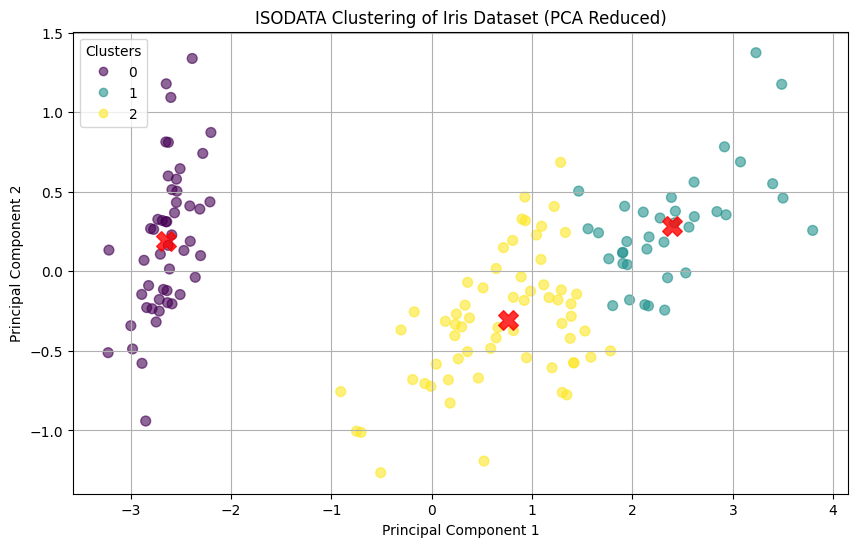

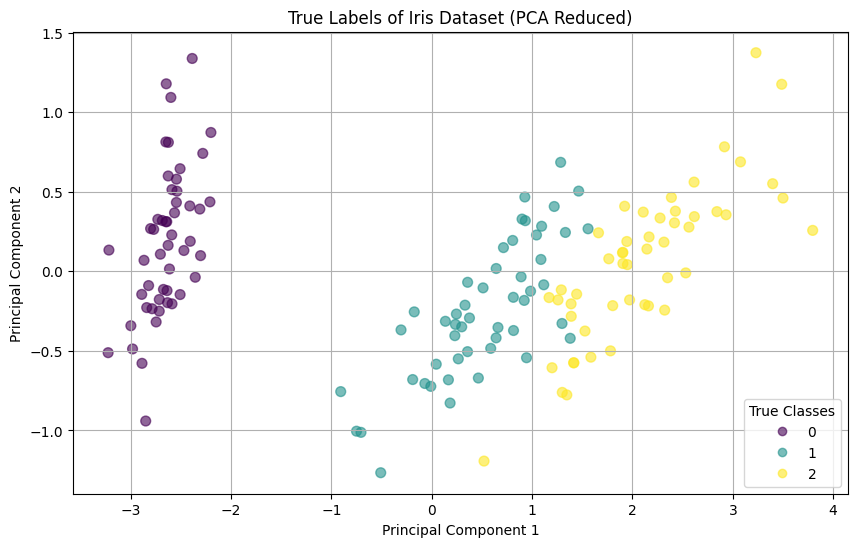

In [8]:
# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_iris)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot data points, colored by their assigned ISODATA cluster label
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=iris_labels, cmap='viridis', s=50, alpha=0.6)

# Plot the final ISODATA cluster centers
if iris_cluster_centers:
    # Transform cluster centers to the PCA space for plotting
    iris_cluster_centers_pca = pca.transform(np.array(iris_cluster_centers))
    plt.scatter(iris_cluster_centers_pca[:, 0], iris_cluster_centers_pca[:, 1], c='red', s=200, alpha=0.8, marker='X', label='Cluster Centers')

plt.title('ISODATA Clustering of Iris Dataset (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()

# Optional: Plot true labels for comparison
plt.figure(figsize=(10, 6))
scatter_true = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=iris.target, cmap='viridis', s=50, alpha=0.6)
plt.title('True Labels of Iris Dataset (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter_true.legend_elements(), title="True Classes")
plt.grid(True)
plt.show()


Adjusted Rand Score (ISODATA): 0.7172759168337549
Adjusted Rand Score (KMeans): 0.7302382722834697


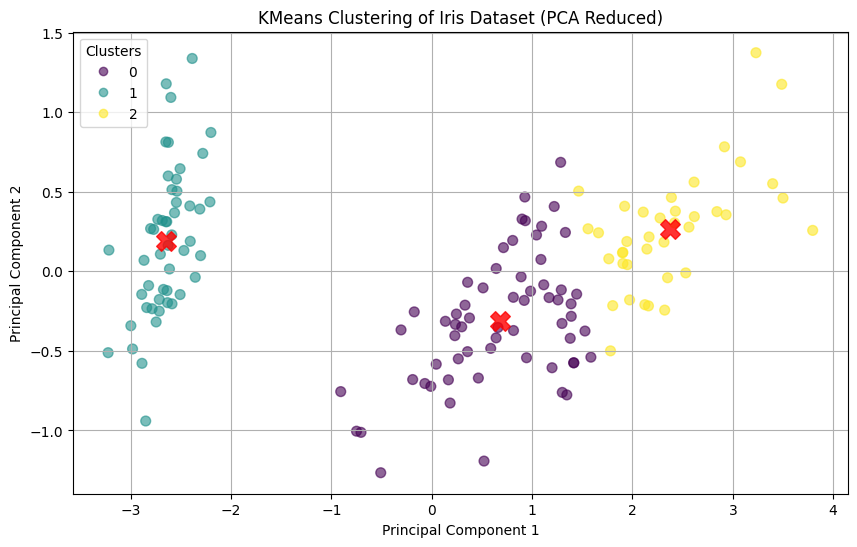

In [9]:
n_clusters_kmeans = 3

kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init=10) # n_init=10 runs 10 times with different centroids
kmeans_labels = kmeans.fit_predict(X_iris)
kmeans_cluster_centers = kmeans.cluster_centers_


# Optionally, compare ISODATA labels to KMeans labels (shows agreement between algorithms)

isodata_rand_score = adjusted_rand_score(iris.target, iris_labels)
kmeans_rand_score = adjusted_rand_score(iris.target, kmeans_labels)

print(f"Adjusted Rand Score (ISODATA): {isodata_rand_score}")
print(f"Adjusted Rand Score (KMeans): {kmeans_rand_score}")
plt.figure(figsize=(10, 6))

# Plot data points, colored by their assigned KMeans cluster label
scatter_kmeans = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.6)

kmeans_cluster_centers_pca = pca.transform(kmeans_cluster_centers)
plt.scatter(kmeans_cluster_centers_pca[:, 0], kmeans_cluster_centers_pca[:, 1], c='red', s=200, alpha=0.8, marker='X', label='Cluster Centers')

plt.title('KMeans Clustering of Iris Dataset (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter_kmeans.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()


## Palmer Penguins Dataset

Running ISODATA on Palmer Penguins dataset...
ISODATA Start: K_desired=5, I_max_iter=30, THETA_N=10, THETA_S=0.8, THETA_C=1.5
Iter 1/30 | Current Nc: 5
  Discarded 2 clusters (size < THETA_N).
  Attempting SPLIT (Nc=3, K_desired/2=2.5)
    Split 1 cluster(s). New Nc: 4
Iter 2/30 | Current Nc: 4
  Attempting LUMP (Nc=4, 2*K_desired=10)
    Lumped 1 pair(s). New Nc: 3
Iter 3/30 | Current Nc: 3
  Attempting SPLIT (Nc=3, K_desired/2=2.5)
  No split or lump action in this iteration.
Iter 4/30 | Current Nc: 3
  Attempting LUMP (Nc=3, 2*K_desired=10)
  No split or lump action in this iteration.
Iter 5/30 | Current Nc: 3
  Attempting SPLIT (Nc=3, K_desired/2=2.5)
  No split or lump action in this iteration.
Iter 6/30 | Current Nc: 3
  Attempting LUMP (Nc=3, 2*K_desired=10)
  No split or lump action in this iteration.
Iter 7/30 | Current Nc: 3
  Attempting SPLIT (Nc=3, K_desired/2=2.5)
  No split or lump action in this iteration.
Iter 8/30 | Current Nc: 3
  Attempting LUMP (Nc=3, 2*K_desired=10

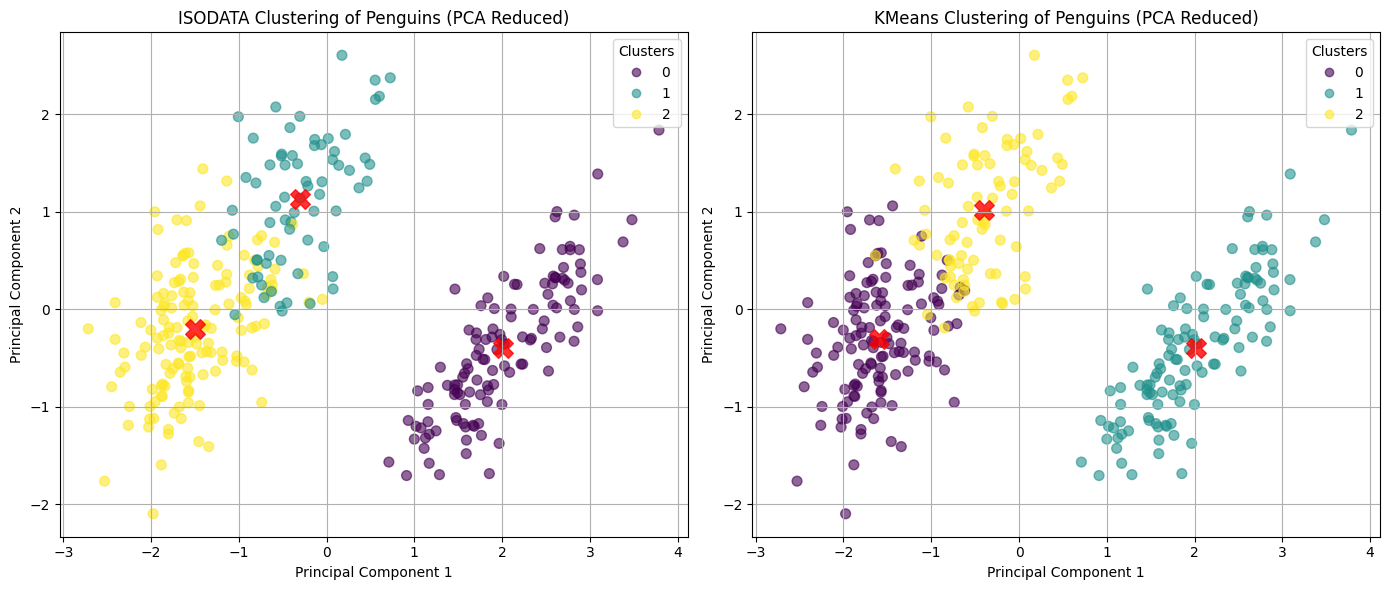

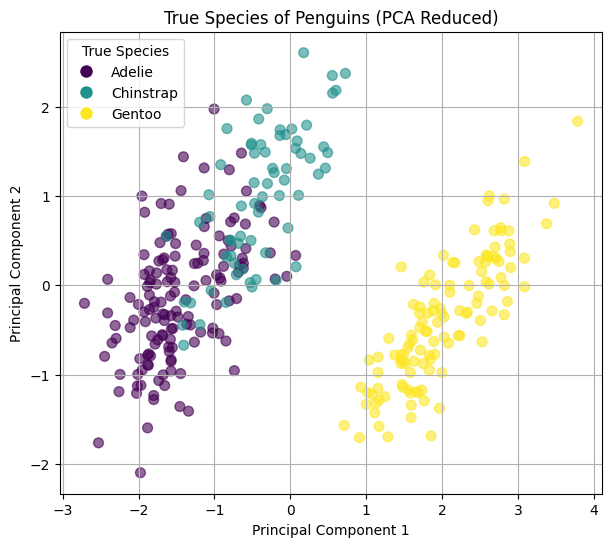


Performance Evaluation (Palmer Penguins):
Adjusted Rand Score (ISODATA vs True Species): 0.890036904672631
Adjusted Rand Score (KMeans vs True Species): 0.7994209859673324

Summary (Palmer Penguins):
ISODATA found 3 clusters.
KMeans found 3 clusters.
ISODATA performed slightly better than KMeans in recovering true species structure (based on ARS).


In [60]:
# prompt: load Palmer Penguins Dataset  Dataset dataset from saborn  and apply on it isodata algo and kmeans and plot the result and evalute the performance of two algo

import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load the Palmer Penguins dataset from seaborn
penguins = sns.load_dataset("penguins").dropna() # Drop rows with missing values

# Select numerical features for clustering
# Exclude 'species' as it's the target, and potentially non-numerical features if any
features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
X_penguins = penguins[features].values

# Standardize the data - important for distance-based algorithms like ISODATA and KMeans
scaler = StandardScaler()
X_penguins_scaled = scaler.fit_transform(X_penguins)

# Apply ISODATA algorithm
print("Running ISODATA on Palmer Penguins dataset...")

# Define ISODATA parameters for Penguins
# We know there are 3 species, so K_desired could be 3.
# Adjust other parameters based on expected cluster properties.
K_desired_penguins = 5  # Aiming for the number of known species
THETA_N_penguins = 10   # Minimum number of samples per cluster (adjust based on dataset size)
THETA_S_penguins = 0.8 # Maximum allowed standard deviation for splitting (adjust based on scaled data variance)
THETA_C_penguins = 1.5 # Minimum distance between cluster centers for lumping (adjust based on scaled data distances)
L_max_lump_penguins = 2 # Maximum number of pairs to lump
I_max_iter_penguins = 30 # Maximum iterations
gamma_split_penguins = 0.5 # Splitting factor

penguins_cluster_centers_isodata, penguins_labels_isodata = isodata_flowchart_core(
    X_penguins_scaled, # Use scaled data
    K_desired=K_desired_penguins,
    THETA_N=THETA_N_penguins,
    THETA_S=THETA_S_penguins,
    THETA_C=THETA_C_penguins,
    L_max_lump=L_max_lump_penguins,
    I_max_iter=I_max_iter_penguins,
    gamma_split=gamma_split_penguins
)

print("\nISODATA on Palmer Penguins completed.")
print(f"Final number of ISODATA clusters: {len(penguins_cluster_centers_isodata)}")

# Apply KMeans algorithm
# Use the desired number of clusters, which we know is 3 for penguins.
n_clusters_kmeans_penguins = 3

kmeans_penguins = KMeans(n_clusters=n_clusters_kmeans_penguins, random_state=42, n_init=10)
kmeans_labels_penguins = kmeans_penguins.fit_predict(X_penguins_scaled) # Use scaled data
kmeans_cluster_centers_penguins = kmeans_penguins.cluster_centers_

print("\nKMeans on Palmer Penguins completed.")

# --- Plot Results (using PCA for visualization as Penguins has 4 numerical features) ---
pca_penguins = PCA(n_components=2)
X_penguins_pca = pca_penguins.fit_transform(X_penguins_scaled) # Use scaled data for PCA

plt.figure(figsize=(14, 6))

# Plot ISODATA Results
plt.subplot(1, 2, 1)
# Handle case where ISODATA might not produce any clusters or labels
if penguins_labels_isodata is not None and len(penguins_labels_isodata) == len(X_penguins_scaled):
    scatter_isodata_penguins = plt.scatter(X_penguins_pca[:, 0], X_penguins_pca[:, 1], c=penguins_labels_isodata, cmap='viridis', s=50, alpha=0.6)
    if penguins_cluster_centers_isodata:
        # Transform cluster centers to the PCA space for plotting
        penguins_cluster_centers_isodata_pca = pca_penguins.transform(np.array(penguins_cluster_centers_isodata))
        plt.scatter(penguins_cluster_centers_isodata_pca[:, 0], penguins_cluster_centers_isodata_pca[:, 1], c='red', s=200, alpha=0.8, marker='X', label='Cluster Centers')
    plt.legend(*scatter_isodata_penguins.legend_elements(), title="Clusters")
else:
     plt.scatter(X_penguins_pca[:, 0], X_penguins_pca[:, 1], c='gray', s=50, alpha=0.6)
     plt.text(0, 0, "ISODATA Failed/No Clusters", ha='center', va='center', color='red', fontsize=12)

plt.title('ISODATA Clustering of Penguins (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

# Plot KMeans Results
plt.subplot(1, 2, 2)
scatter_kmeans_penguins = plt.scatter(X_penguins_pca[:, 0], X_penguins_pca[:, 1], c=kmeans_labels_penguins, cmap='viridis', s=50, alpha=0.6)
# Transform cluster centers to the PCA space for plotting
kmeans_cluster_centers_penguins_pca = pca_penguins.transform(kmeans_cluster_centers_penguins)
plt.scatter(kmeans_cluster_centers_penguins_pca[:, 0], kmeans_cluster_centers_penguins_pca[:, 1], c='red', s=200, alpha=0.8, marker='X', label='Cluster Centers')

plt.title('KMeans Clustering of Penguins (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter_kmeans_penguins.legend_elements(), title="Clusters")
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot True Labels for Comparison (using species)
plt.figure(figsize=(7, 6))
# Map species names to numerical labels for plotting
species_mapping = {species: i for i, species in enumerate(penguins['species'].unique())}
true_labels_penguins = penguins['species'].map(species_mapping)

scatter_true_penguins = plt.scatter(X_penguins_pca[:, 0], X_penguins_pca[:, 1], c=true_labels_penguins, cmap='viridis', s=50, alpha=0.6)
plt.title('True Species of Penguins (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# Create legend with species names
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=species,
                              markerfacecolor=scatter_true_penguins.cmap(scatter_true_penguins.norm(species_mapping[species])), markersize=10)
                   for species in species_mapping]
plt.legend(handles=legend_elements, title="True Species")

plt.grid(True)
plt.show()


# --- Evaluate Performance ---

# Use Adjusted Rand Score to compare cluster assignments to true labels (species)

# Handle cases where ISODATA might return no clusters or labels
if penguins_labels_isodata is not None and len(penguins_labels_isodata) == len(true_labels_penguins) and len(set(penguins_labels_isodata)) > 1:
    isodata_rand_score_penguins = adjusted_rand_score(true_labels_penguins, penguins_labels_isodata)
else:
    isodata_rand_score_penguins = -1 # Indicate failure or inability to compute ARS

kmeans_rand_score_penguins = adjusted_rand_score(true_labels_penguins, kmeans_labels_penguins)

print("\nPerformance Evaluation (Palmer Penguins):")
print(f"Adjusted Rand Score (ISODATA vs True Species): {isodata_rand_score_penguins}")
print(f"Adjusted Rand Score (KMeans vs True Species): {kmeans_rand_score_penguins}")

# Comparison summary
print("\nSummary (Palmer Penguins):")
print(f"ISODATA found {len(penguins_cluster_centers_isodata)} clusters.")
print(f"KMeans found {n_clusters_kmeans_penguins} clusters.")

if isodata_rand_score_penguins > kmeans_rand_score_penguins:
    print("ISODATA performed slightly better than KMeans in recovering true species structure (based on ARS).")
elif kmeans_rand_score_penguins > isodata_rand_score_penguins:
    print("KMeans performed slightly better than ISODATA in recovering true species structure (based on ARS).")
else:
     print("ISODATA and KMeans performance in recovering true species structure is comparable (based on ARS).")

# Additional Notes:
# - ISODATA's final number of clusters can be different from K_desired. In this run, it aimed for K_desired_penguins=3.
# - KMeans requires explicitly setting the number of clusters.
# - Performance heavily depends on ISODATA parameters (THETA_N, THETA_S, THETA_C, etc.). Tuning is often required.
# - The plots show how well each algorithm separated the data points corresponding to the different penguin species.

